In [8]:
%load_ext lab_black

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# The Math of Bingo

In [9]:
N = int(2e6)
price = 150
frac_prizes = 0.65

In [10]:
profit = N * price
profit

300000000

In [11]:
prize_pool = int(frac_prizes * profit)
prize_pool

195000000

Столото утверждают, что 65% раздадут в призовых. Значит, выигрышей должно быть много, так?..

<img width="40%" src="https://i.imgflip.com/5c7lwq.png?a461688">

In [12]:
df = pd.DataFrame(
    data={
        "prize": [
            0,
            50,
            75,
            150,
            250,
            1500,
            2500,
            5000,
            25000,
            50000,
            500000,
            1500000,
            10000000,
        ],
        "count": [
            None,
            1.2e6,
            6e5,
            1e5,
            5e4,
            1e4,
            1e3,
            600,
            200,
            40,
            20,
            10,
            1,
        ],
    }
)

df["count"] = df["count"].fillna(N - df["count"].sum()).astype(int)
df["count_cum"] = df["count"].cumsum()
df["prize"] -= price

In [13]:
df

,prize,count,count_cum
0,-150,38129,38129
1,-100,1200000,1238129
2,-75,600000,1838129
3,0,100000,1938129
4,100,50000,1988129
5,1350,10000,1998129
6,2350,1000,1999129
7,4850,600,1999729
8,24850,200,1999929
9,49850,40,1999969


## Monte Carlo experiment

In [14]:
monte_carlo_num = 100_000

In [15]:
tickets = np.arange(1, N + 1)
np.random.shuffle(tickets)

tickets_ids = tickets[:monte_carlo_num]
profit_distr = [df["prize"][(x <= df["count_cum"]).argmax()] for x in tqdm(tickets_ids)]

100%|█████████████████████████████████| 100000/100000 [01:27<00:00, 1149.08it/s]


In [16]:
s = pd.Series(profit_distr).value_counts()
s = s.loc[[x for x in df["prize"].values if x in s.index]]

In [17]:
s

-150         1928
-100        59755
-75         30145
 0           5018
 100         2559
 1350         499
 2350          50
 4850          30
 24850         13
 49850          2
 1499850        1
dtype: int64

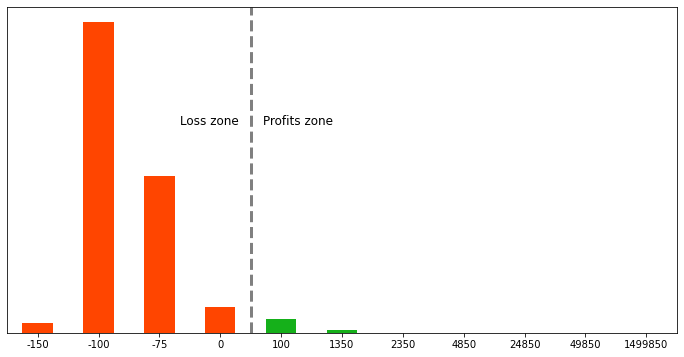

In [19]:
plt.figure(figsize=(12, 6))
s.plot.bar(ax=plt.gca(), rot=0, color=["#FF4500"] * 4 + ["#15B01A"] * 7)
plt.axvline(x=3.5, c="gray", ls="--", lw=3)
plt.text(x=3.7, y=40000, s="Profits zone", size="large")
plt.text(x=3.3, y=40000, s="Loss zone", size="large", ha="right")
plt.tick_params(axis="both", left=False, labelleft=False)
plt.show()

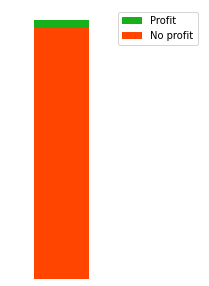

In [20]:
profit_no_profit = pd.DataFrame(
    [
        s.loc[[-150, -100, -75, 0]].sum(),
        s.loc[[x for x in s.index if x not in [-150, -100, -75, 0]]].sum(),
    ]
).T.rename(columns={0: "No profit", 1: "Profit"})

plt.figure(figsize=(3.5, 5))
profit_no_profit.plot.bar(
    rot=0, stacked=True, ax=plt.gca(), color=["#FF4500", "#15B01A"]
)
plt.xlim(-0.5, 1.3)
plt.axis("off")
plt.gca().set(xlabel=None, ylabel=None)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.show()

In [21]:
profit_no_profit

,No profit,Profit
0,96846,3154


In [22]:
a = s[s.index[s.index > 0]]

a = [y for i in range(len(a)) for y in [a.index[i]] * a.iloc[i]]

x = (pd.Series(a) > 100).argmax() / len(a)
x, 1 - x

(0.8113506658211794, 0.18864933417882057)

In [23]:
f"Шанс, что тебе выпадет билет и принесет больше сотки (всего лишь сотки рублей, не тысяч), равен {profit_no_profit.loc[0, 'Profit'] / N*100:.2f}%"

'Шанс, что тебе выпадет билет и принесет больше сотки (всего лишь сотки рублей, не тысяч), равен 0.16%'

In [24]:
profit_no_profit

,No profit,Profit
0,96846,3154


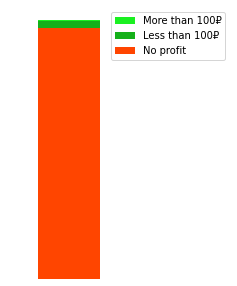

In [26]:
df_profits_zoomed = pd.DataFrame(
    data={
        "No profit": [profit_no_profit.loc[0, "No profit"]],
        "Less than 100₽": [int(profit_no_profit.loc[0, "Profit"] * x)],
        "More than 100₽": [int(profit_no_profit.loc[0, "Profit"] * (1 - x))],
    }
)

# (14/255., 14/255., 156/255.)

plt.figure(figsize=(4, 5))
df_profits_zoomed.plot.bar(
    rot=0, stacked=True, ax=plt.gca(), color=["#FF4500", "#15B01A", "#1af021"]
)
plt.xlim(-0.5, 1.3)
plt.axis("off")
plt.gca().set(xlabel=None, ylabel=None)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc=1)
plt.show()